In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.impute import KNNImputer
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV


## Load Data 

Kaggle Dataset: https://www.kaggle.com/datasets/brycecf/give-me-some-credit-dataset/data?select=cs-training.csv

In [3]:
# Load dataset
df = pd.read_csv(r"data\cs-training.csv")

# Check invalid MonthlyIncome entries
(df["MonthlyIncome"] == 0).value_counts()

# Drop rows with missing dependents
df = df.dropna(subset=["NumberOfDependents"])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 146076 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            146076 non-null  int64  
 1   SeriousDlqin2yrs                      146076 non-null  int64  
 2   RevolvingUtilizationOfUnsecuredLines  146076 non-null  float64
 3   age                                   146076 non-null  int64  
 4   NumberOfTime30-59DaysPastDueNotWorse  146076 non-null  int64  
 5   DebtRatio                             146076 non-null  float64
 6   MonthlyIncome                         120269 non-null  float64
 7   NumberOfOpenCreditLinesAndLoans       146076 non-null  int64  
 8   NumberOfTimes90DaysLate               146076 non-null  int64  
 9   NumberRealEstateLoansOrLines          146076 non-null  int64  
 10  NumberOfTime60-89DaysPastDueNotWorse  146076 non-null  int64  
 11  Numbe

## KNN Imputation for Missing Values

The `MonthlyIncome` feature contains many missing values.  
To avoid losing a large portion of the data, I use KNN Imputation.


In [4]:
# Imputation with KNN for MonthlyIncome

imputer = KNNImputer(n_neighbors=5)

# Columns for imputation
columns = ["MonthlyIncome", "NumberOfDependents", "age", "DebtRatio", "NumberOfOpenCreditLinesAndLoans"]

imputed_values = imputer.fit_transform(df[columns])

df[columns] = imputed_values

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 146076 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            146076 non-null  int64  
 1   SeriousDlqin2yrs                      146076 non-null  int64  
 2   RevolvingUtilizationOfUnsecuredLines  146076 non-null  float64
 3   age                                   146076 non-null  float64
 4   NumberOfTime30-59DaysPastDueNotWorse  146076 non-null  int64  
 5   DebtRatio                             146076 non-null  float64
 6   MonthlyIncome                         146076 non-null  float64
 7   NumberOfOpenCreditLinesAndLoans       146076 non-null  float64
 8   NumberOfTimes90DaysLate               146076 non-null  int64  
 9   NumberRealEstateLoansOrLines          146076 non-null  int64  
 10  NumberOfTime60-89DaysPastDueNotWorse  146076 non-null  int64  
 11  Numbe

## Exploratory Data Analysis 

- Basic statistics
- Correlation/Heatmap
- Feature Importances with Random Forest

In [8]:
# drop index column
df = df.drop(columns= "Unnamed: 0")

# Basic statistics
df.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,146076.000000,146076.000000,146076.000000,146076.000000,146076.000000,1.460760e+05,146076.000000,146076.000000,146076.000000,146076.000000,146076.000000
mean,0.067410,5.922272,52.099277,0.407945,333.373603,5.553501e+03,8.529279,0.250698,1.029717,0.225027,0.757222
std,0.250732,250.070774,14.604005,4.002747,1943.906679,1.330096e+04,5.149533,3.977197,1.132774,3.962048,1.115086
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.031018,41.000000,0.000000,0.171764,2.050000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.158818,52.000000,0.000000,0.357751,4.500000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.563684,62.000000,0.000000,0.766117,7.500000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,50708.000000,107.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


## Heatmap

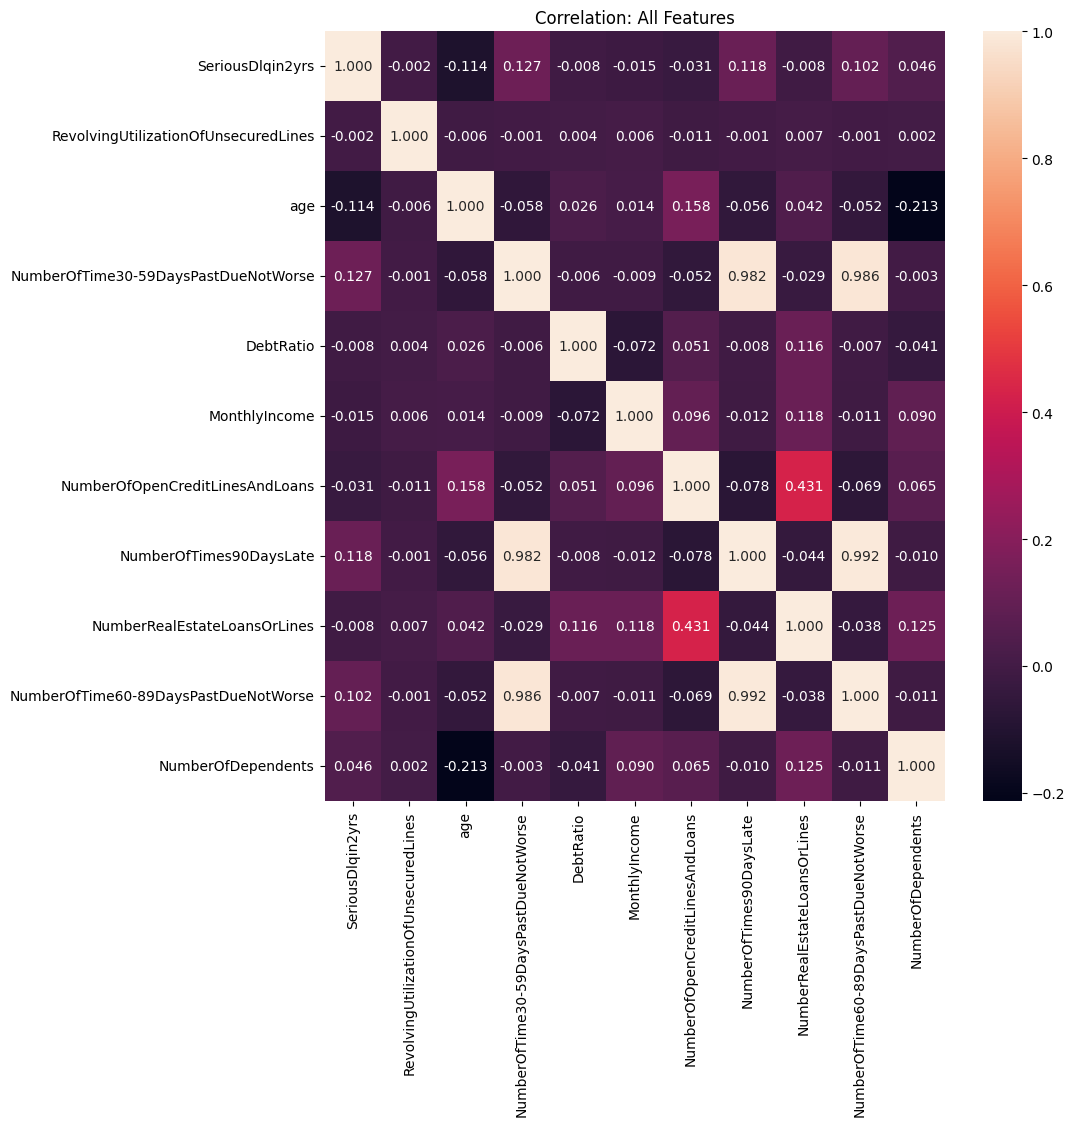

In [9]:
# Correlation

corr = df.corr()
corr_target = df.corr()["SeriousDlqin2yrs"].sort_values(ascending=False)

# Heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=True, fmt=".3f")
plt.title("Correlation: All Features")
plt.show()

## Feature Importances

In [10]:
# Random Forest for Feature Analysis 

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X = df.iloc[:, 1:]
y = df["SeriousDlqin2yrs"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


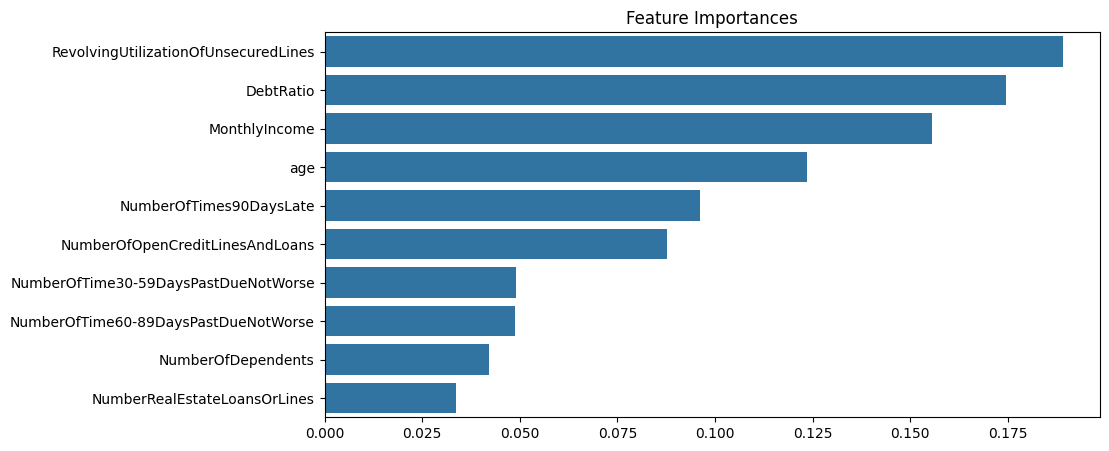

RevolvingUtilizationOfUnsecuredLines    0.189062
DebtRatio                               0.174629
MonthlyIncome                           0.155558
age                                     0.123523
NumberOfTimes90DaysLate                 0.096150
NumberOfOpenCreditLinesAndLoans         0.087674
NumberOfTime30-59DaysPastDueNotWorse    0.048990
NumberOfTime60-89DaysPastDueNotWorse    0.048705
NumberOfDependents                      0.042151
NumberRealEstateLoansOrLines            0.033558
dtype: float64

In [ ]:
# Feature Importances

importances = pd.Series(rf.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)
plt.figure(figsize=(10, 5))
sns.barplot(importances, orient="h")
plt.title("Feature Importances")
plt.show()
importances

## Model Evaluation (Baseline)

- Model: Random Forest (from Feature Importances)

In [11]:
#Random Forest Prediction

y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:,1] 

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy )
print("ROC-AUC:", roc_auc )
print("F1_score:", f1)
print("Precision_score:", precision)
print("recall_score:", recall)



Accuracy: 0.935001369112815
ROC-AUC: 0.8348972516538312
F1_score: 0.27546737886302936
Precision_score: 0.5316642120765832
recall_score: 0.1858908341915551


## Grid Search 

In [ ]:
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 5, 10, 15],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2", None]
}

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best ROC-AUC (CV):", grid_search.best_score_)

# Evaluate tuned model
best_rf = grid_search.best_estimator_
y_proba_best = best_rf.predict_proba(X_test)[:, 1]
print("Test ROC-AUC:", roc_auc_score(y_test, y_proba_best))

The full Grid Search was previously executed. Due to its runtime of approximately 36 hours, it was not re-run in this notebook.

Best Parameters:
- max_depth=10
- max_features= "sqrt"
- min_samples_leaf=4
- min_samples_split=10
- n_estimators=300

## Model Evaluation (GridSearch)

- Model: Random Forest with Grid Search hyperparameter tuning

In [11]:
# Random Forest after Grid Search

rf_after = RandomForestClassifier(max_depth=10, max_features= "sqrt", min_samples_leaf=4, min_samples_split=10, n_estimators=300, random_state=42)

rf_after.fit(X_train, y_train)

y_pred_after = rf_after.predict(X_test)
y_prob_after = rf_after.predict_proba(X_test)[:,1]

accuracy_after = accuracy_score(y_test, y_pred_after)
roc_auc_after = roc_auc_score(y_test, y_prob_after)
f1_after = f1_score(y_test, y_pred_after)
precision_after = precision_score(y_test, y_pred_after)
recall_after = recall_score(y_test, y_pred_after)

print("Accuracy:", accuracy_after )
print("ROC-AUC:", roc_auc_after )
print("F1_score:", f1_after)
print("Precision_score:", precision_after)
print("recall_score:", recall_after)


Accuracy: 0.9369181270536692
ROC-AUC: 0.8556594813422955
F1_score: 0.2559547840129189
Precision_score: 0.5925233644859813
recall_score: 0.16323377960865088


## Threshold Tunning

In [12]:
## Threshold Tunning

y_proba = rf.predict_proba(X_test)[:, 1]

# Thresholds
thresholds = np.arange(0, 1.1, 0.1)

best_f1 = 0
best_threshold = 0

for t in thresholds:
    y_pred = []
    for p in y_proba:
        if p >= t:
            y_pred.append(1)
        else:
            y_pred.append(0)
    
    # F1-Score 
    current_f1 = f1_score(y_test, y_pred)
    
    # Best F1-Score
    if current_f1 > best_f1:
        best_f1 = current_f1
        best_threshold = t

print("Best Threshold:", best_threshold)
print("Best F1:", best_f1)

y_pred_final = []
for p in y_proba:
    if p >= best_threshold:
        y_pred_final.append(1)
    else:
        y_pred_final.append(0)


Best Threshold: 0.2
Best F1: 0.3953304313415117


## Model Evaluation (Threshold Tuning)

- Model: Random Forest after Grid Search hyperparameter tuning and Threshold Tuning

In [ ]:
# Metrices after Threshold-Tuning

y_prob_after = rf_after.predict_proba(X_test)[:,1]

accuracy_final = accuracy_score(y_test, y_pred_final)
roc_auc_final = roc_auc_score(y_test, y_prob_after)
f1_final = f1_score(y_test, y_pred_final)
precision_final = precision_score(y_test, y_pred_final)
recall_final = recall_score(y_test, y_pred_final)

print("Accuracy:", accuracy_final )
print("ROC-AUC:", roc_auc_final )
print("F1_score:", f1_final)
print("Precision_score:", precision_final)
print("recall_score:", recall_final)


Accuracy: 0.8953997809419496
ROC-AUC: 0.8556594813422955
F1_score: 0.3953304313415117
Precision_score: 0.32101542416452444
recall_score: 0.5144181256436663


## Save Dataframes 

In [ ]:
# Generating Dataframe for Metrices
data = {
    'Accuracy': [accuracy, accuracy_after, accuracy_final],
    'ROC-AUC': [roc_auc, roc_auc_after, roc_auc_final],
    'F1-Score': [f1, f1_after, f1_final],
    'Precision': [precision, precision_after, precision_final],
    'Recall': [recall, recall_after, recall_final]
}

index_labels = ['Random Forest', 'Grid-Search', 'Threshold-Tuning']
metrics_df = pd.DataFrame(data, index=index_labels)


In [15]:
#Dataframes for Visualisation Tools

metrics_df.to_csv("data\metrices.csv")

# save Train df
save_df_train = pd.concat([X_train, y_train], axis=1)
save_df_train.to_csv(r"data\train_clean.csv", index=False)


importances = importances.reset_index()
importances = importances.rename(columns={"index": "Features", 0: "Values"})
importances.to_csv(r"data\importances.csv", index=False)
